## Stock Price Analysis with Pandas and Sci-kit Learn

### Key learning objectvies

1. Using dataframe object to represent time series data
2. Sci-kit Learn linear_model class (Ordinary Least Squares, Ridge Regression and Lasso)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

Downloaded three years of IBM and Microsoft stock data from https://finance.yahoo.com/quote/IBM/history?p=IBM

In [19]:
# Read into the data frame and re-index by date
df = pd.read_csv('IBM.csv')
df_msft = pd.read_csv('MSFT.csv')
df.index = df['Date']
df_msftt = df_msft['Date']

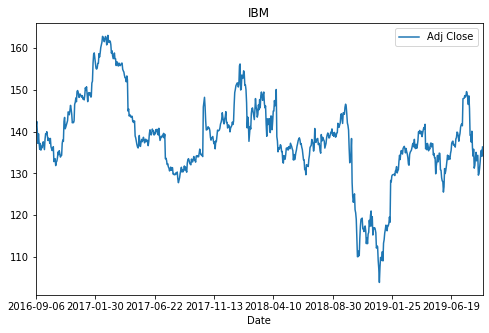

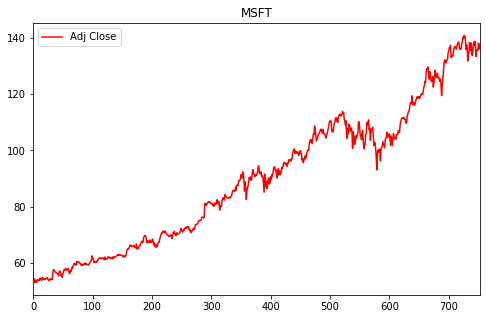

In [24]:
plt.rcParams['figure.figsize'] = [8, 5]
df.plot(y = 'Adj Close', title='IBM')
df_msft.plot(y = 'Adj Close', title='MSFT', color='r')

Auto-correlation plot shows how much of historical data is correlated to current date.

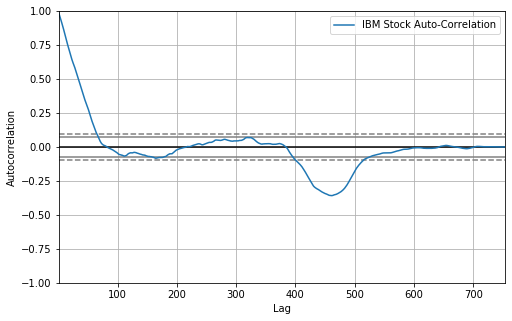

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Adj Close'], label = 'IBM Stock Auto-Correlation')

We see that Lag = 1 data is unsurprisingly very correlated to current date's stock price. However, we also observe a negative correlation around Lag = 450

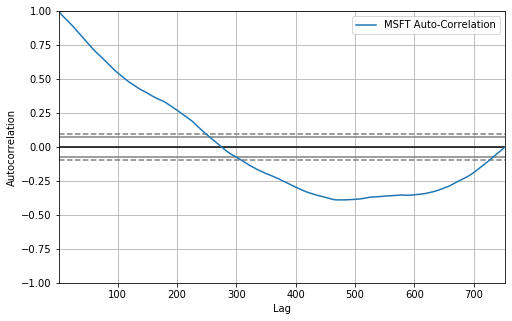

In [27]:
autocorrelation_plot(df_msft['Adj Close'], label = 'MSFT Auto-Correlation')

## Prediction

We will now move onto prediction using regression methods.

In [28]:
window_size = 7

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [29]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [30]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [31]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

In [32]:
# Train
ols_model = linear_model.LinearRegression()
ols_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ols_model.predict(X_train)
y_pred_ridge = ols_model.predict(X_test)

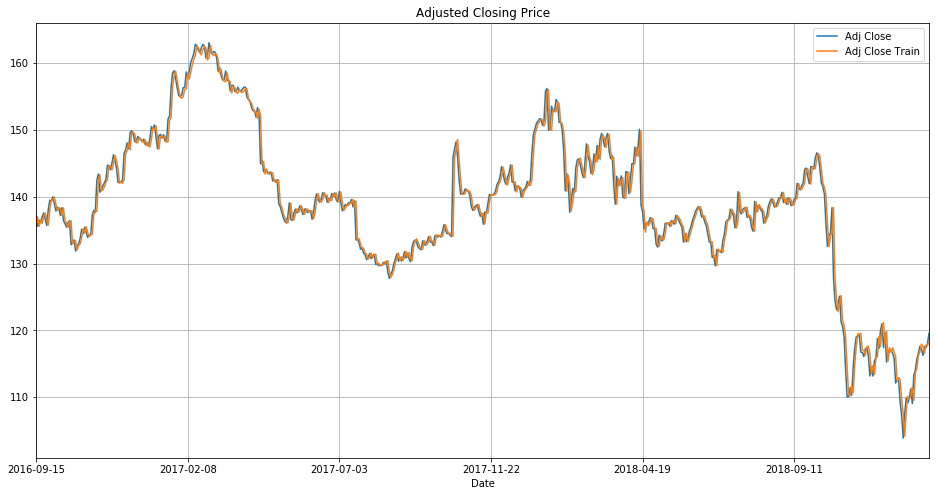

In [33]:
# Plot what it looks like for the training data
df_ols = df.copy()
df_ols.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ols = df_ols.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ols['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ols.plot(label='IBM', figsize=(16,8), title='Adjusted Closing Price', grid=True)

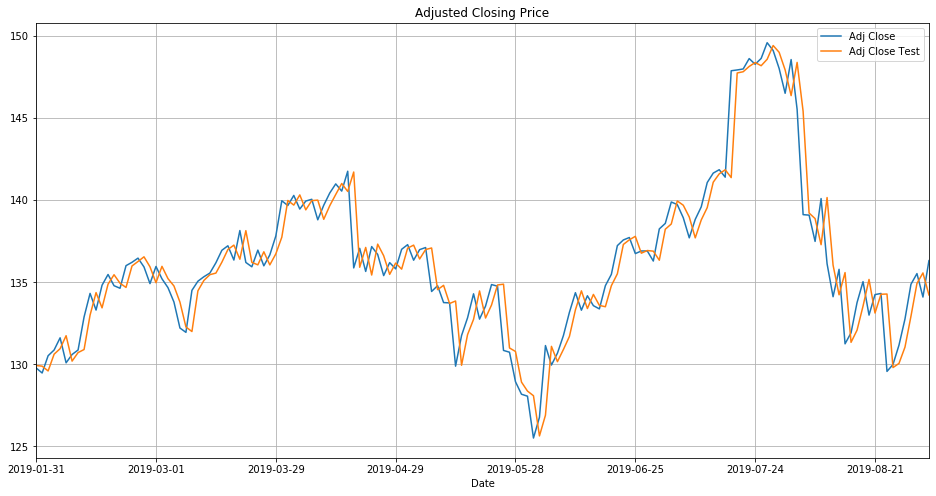

In [34]:
# Same for the test
df_ols = df.copy()
df_ols.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ols = df_ols.iloc[ind_split+window_size:]
df_ols['Adj Close Test'] = y_pred_ridge
df_ols.plot(label='IBM', figsize=(16,8), title='Adjusted Closing Price', grid=True)

actual = df_ols['Adj Close']
predicted = df_ols['Adj Close Test']
MAPE_test = np.mean(100.0 * np.abs(actual - predicted)/np.abs(actual))

## Mean Absolute Percent Error (MAPE) result

In [108]:
MAPE_test

0.8598405801906064

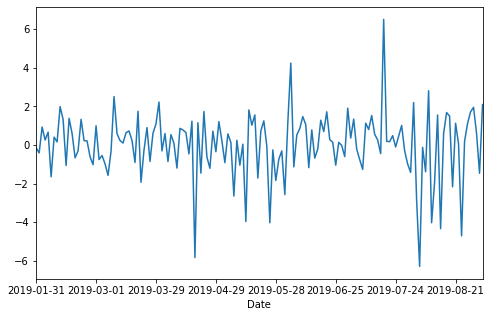

In [35]:
(actual - predicted).plot()

We see that although our MAPE appears to be small, our errors are random, meaning the model has no more predictive power than a coin flip, if we were to use it to predict on a day-to-day basis

Next, we repeat the experiment for the Ridge and Lasso regression methods.

In [37]:
# We will create a reusable function that does pre-processing and model prediction and printing out graphs 
# It is obviously doing way too many things, but I'm tired, and this will do :)
def process(df, model):
    window_size = 7

    # Get indices of access for the data
    num_samples = len(df) - window_size
    indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)
    data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples
    
    X = data[:,:-1] 
    y = data[:,-1] 
    
    # Train and test split
    split_fraction = 0.8
    ind_split = int(split_fraction * num_samples)
    X_train = X[:ind_split]
    y_train = y[:ind_split]
    X_test = X[ind_split:]
    y_test = y[ind_split:]
    # Train
    model.fit(X_train, y_train)

    # Infer
    y_pred_train_ridge = model.predict(X_train)
    y_pred_ridge = model.predict(X_test)
    
    # Plot what it looks like for the training data
    df_pred = df.copy()
    df_pred.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    df_pred = df_pred.iloc[window_size:ind_split] # Past 32 days we don't know yet
    df_pred['Adj Close Train'] = y_pred_train_ridge[:-window_size]
    df_pred.plot(label='IBM', figsize=(16,8), title='Adjusted Closing Price', grid=True)
    
    # Same for the test
    df_pred = df.copy()
    df_pred.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    df_pred = df_pred.iloc[ind_split+window_size:]
    df_pred['Adj Close Test'] = y_pred_ridge
    df_pred.plot(label='IBM', figsize=(16,8), title='Adjusted Closing Price', grid=True)

    actual = df_pred['Adj Close']
    predicted = df_pred['Adj Close Test']
    MAPE_test = np.mean(100.0 * np.abs(actual - predicted)/np.abs(actual))
    
    return MAPE_test

## Ridge Regression

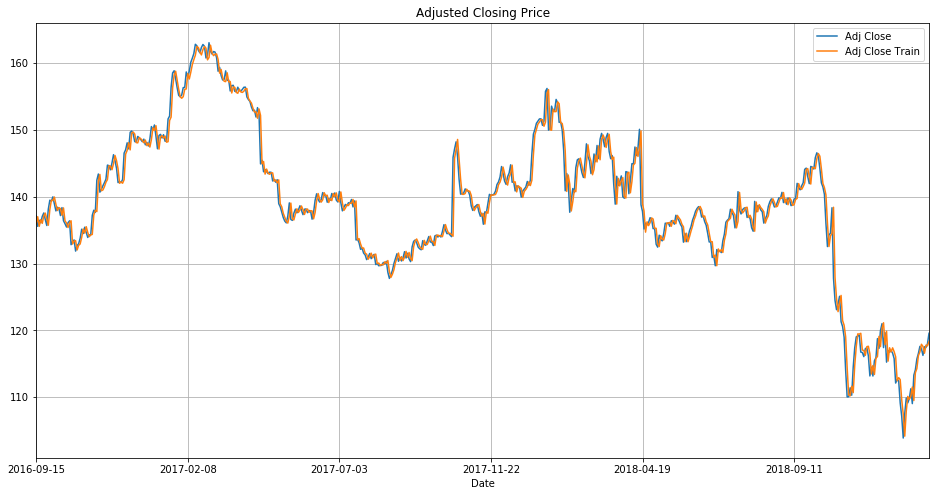

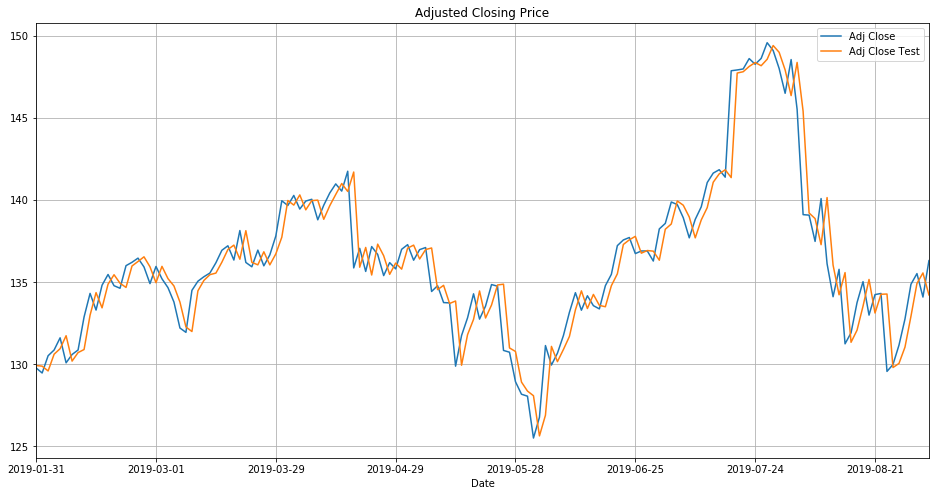

In [39]:
MAPE_ridge = process(df, linear_model.Ridge())

In [40]:
MAPE_ridge

0.8613007842464079

MAPE for ridge is slightly worse than OLS

## Lasso Regression

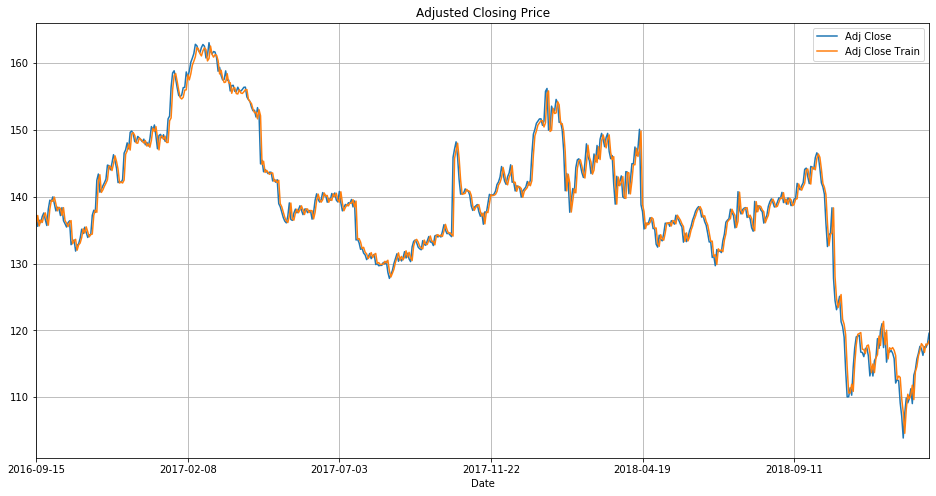

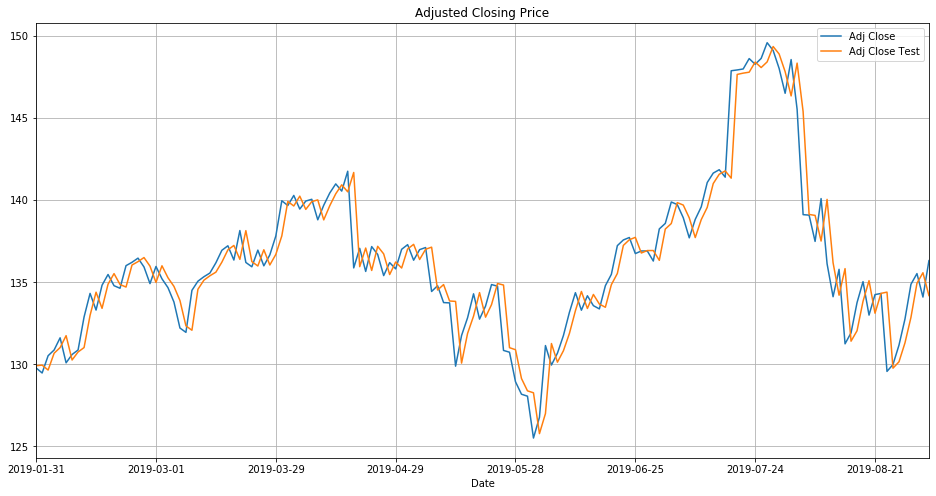

In [43]:
MAPE_lasso = process(df, linear_model.Lasso())

In [44]:
MAPE_lasso

0.8591510155431752

About the same...


# The end